# Optimizacija hiperparametrov KNN

In [1]:
%run __A_knjiznice.py

# Import specific elements from the script
from __A_knjiznice import *
from __B_funkcije import *
import __C_konstante as kon
%matplotlib inline

In [2]:
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load your dataset
df = pd.read_csv(f'{kon.path_files}/molekulski_prstni_odtisi/df_circular.csv')
y = df[['Activity']].values.ravel()  # Assuming 'Activity' is the target
X = df.iloc[:, 3:]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=kon.random_seed, stratify=y)

# Define cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=kon.random_seed)  # Increased folds for more robustness

# Define the Optuna optimization function
def objective(trial):
    # Define hyperparameters for KNeighborsClassifier
    n_neighbors = trial.suggest_int('n_neighbors', 3, 10)  # Increased minimum for n_neighbors to avoid overfitting
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])  # Tuning weight function
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])  # Tuning distance metric
    
    # Define feature selection (SelectKBest)
    k_best = trial.suggest_int('k_best', 5, 300)  # Limit number of features to select to half of the features
    
    # Select the fraction of variance to retain for PCA
    pca_fraction = trial.suggest_float('pca_fraction', 0.1, 0.75)  # Fraction of variance to retain
    
    # Create the pipeline with PCA (always on), VarianceThreshold, SelectKBest, and scaling
    steps = [
        ('variance_threshold', VarianceThreshold()),  # Apply VarianceThreshold to remove low-variance features
        ('select_k_best', SelectKBest(score_func=chi2, k=k_best)),  # Apply SelectKBest with chi2 scoring function
        ('pca', PCA(n_components=pca_fraction, svd_solver='full')),  # Always apply PCA with the selected fraction of variance
        ('knn', KNeighborsClassifier(n_neighbors=n_neighbors, 
                                     weights=weights, 
                                     metric=metric, 
                                     n_jobs=-1))  # KNeighborsClassifier
    ]
    
    # Create the pipeline with the selected steps
    model = Pipeline(steps)
    
    # Cross-validation: Optimize based on mean accuracy
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    return np.mean(cv_scores)  # Return the mean of the cross-validation scores

# Create the Optuna study and optimize it
study = optuna.create_study(direction='maximize')  # We want to maximize accuracy
study.optimize(objective, n_trials=50)  # Number of trials to run (can adjust this)

# Output the best trial results
print('Best trial:')
best_trial = study.best_trial
print(f"  Value: {best_trial.value}")
print(f"  Params: {best_trial.params}")

[I 2024-12-30 18:11:50,508] A new study created in memory with name: no-name-96615058-27be-4f9b-b2f2-fb6d0f665d88
[I 2024-12-30 18:11:53,273] Trial 0 finished with value: 0.7540056412990481 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'metric': 'euclidean', 'k_best': 167, 'pca_fraction': 0.2785948591649368}. Best is trial 0 with value: 0.7540056412990481.
[I 2024-12-30 18:11:56,101] Trial 1 finished with value: 0.8427485611953356 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'metric': 'euclidean', 'k_best': 180, 'pca_fraction': 0.4706050717222706}. Best is trial 1 with value: 0.8427485611953356.
[I 2024-12-30 18:11:59,099] Trial 2 finished with value: 0.7591324793919426 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'metric': 'minkowski', 'k_best': 217, 'pca_fraction': 0.25722578551722686}. Best is trial 1 with value: 0.8427485611953356.
[I 2024-12-30 18:12:01,996] Trial 3 finished with value: 0.7250399857828327 and parameters: {'n_neighbors': 8, 'weigh

Best trial:
  Value: 0.8744327942657424
  Params: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'k_best': 268, 'pca_fraction': 0.7147602478609734}


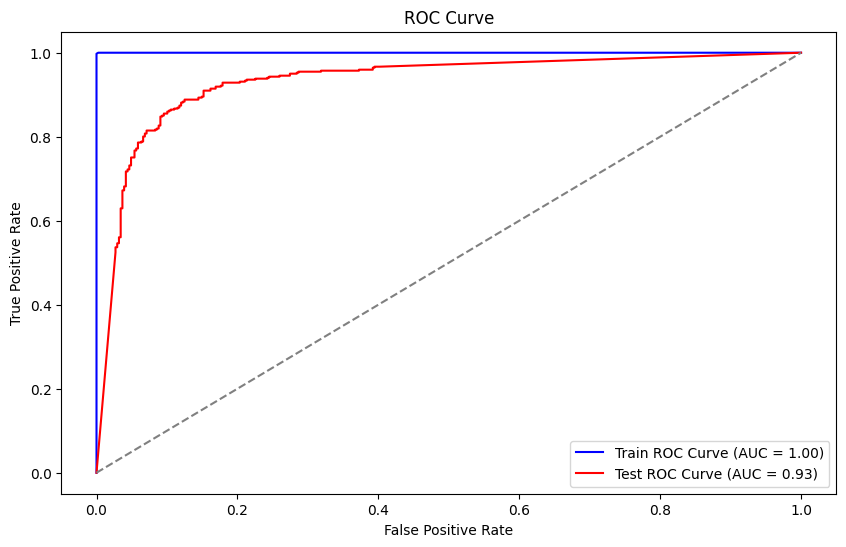

In [3]:
# Extract the best hyperparameters
best_params = best_trial.params
n_neighbors = best_params['n_neighbors']
weights = best_params['weights']
metric = best_params['metric']
k_best = best_params['k_best']
pca_fraction = best_params['pca_fraction']

# Create the final pipeline with the best parameters
final_model = Pipeline([
    ('variance_threshold', VarianceThreshold()),  # Apply VarianceThreshold
    ('select_k_best', SelectKBest(score_func=chi2, k=k_best)),  # Feature selection using SelectKBest
    ('pca', PCA(n_components=pca_fraction, svd_solver='full')),  # PCA with the selected fraction of variance
    ('knn', KNeighborsClassifier(n_neighbors=n_neighbors, 
                                 weights=weights, 
                                 metric=metric, 
                                 n_jobs=-1))  # KNeighborsClassifier with the best parameters
])

# Fit the model on the full training data
final_model.fit(X_train, y_train)

# Predictions for train data
y_train_pred = final_model.predict(X_train)
y_train_prob = final_model.predict_proba(X_train)[:, 1]  # Probabilities for ROC AUC

# Predictions for test data
y_test_pred = final_model.predict(X_test)
y_test_prob = final_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC AUC

# Calculate accuracy and AUC for train and test sets
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_auc = roc_auc_score(y_train, y_train_prob)
test_auc = roc_auc_score(y_test, y_test_prob)

# Plot ROC Curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)

plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, color='blue', label=f'Train ROC Curve (AUC = {train_auc:.2f})')
plt.plot(fpr_test, tpr_test, color='red', label=f'Test ROC Curve (AUC = {test_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

Train Accuracy: 0.9988
Test Accuracy: 0.8794
Train AUC: 1.0000
Test AUC: 0.9324


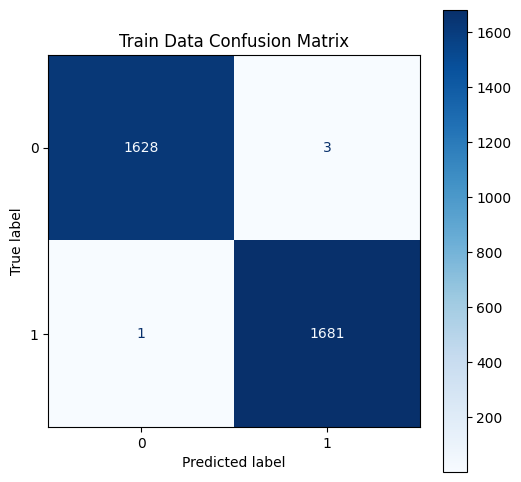

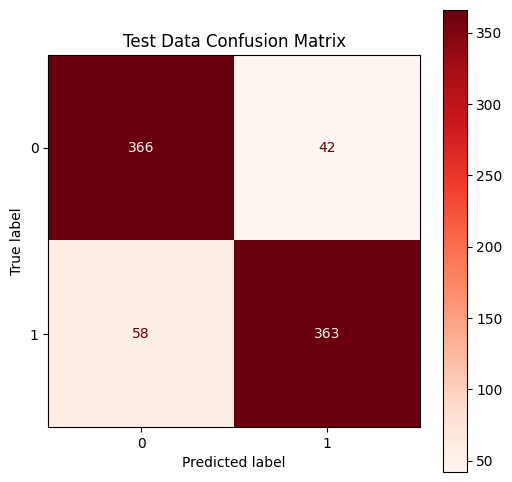

In [4]:
# Confusion Matrix for Train and Test
train_cm = confusion_matrix(y_train, y_train_pred)
test_cm = confusion_matrix(y_test, y_test_pred)

# Print accuracy and AUC scores
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Train AUC: {train_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")


# Display Confusion Matrix for Train data
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay(confusion_matrix=train_cm).plot(cmap='Blues', ax=ax)
ax.set_title('Train Data Confusion Matrix')
plt.show()

# Display Confusion Matrix for Test data
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay(confusion_matrix=test_cm).plot(cmap='Reds', ax=ax)
ax.set_title('Test Data Confusion Matrix')
plt.show()